# 0. Bemol AI Engineering Challenge

## O desafio consiste em:

* Uma análise do perfil do público de clientes da base de dados;
* Segmentar os perfis identificados com base em características úteis para o time de vendas e marketing;
* Fornecer os dados a partir de uma API utilizada para consultas. Disponível em `/src/api/`.

## Foco deste processo:

Para apresentar um pouco do meu trabalho, seguirei os passos:

* **Insights**: Obter informações relevantes sobre a base de dados e dos clientes presentes na mesma. Gerar informação útil para o time de vendas e marketing que possam auxiliar nas estratégias de ambos os times.
* **Segmentação**: Separação entre tipos diferentes de clientes. Esta separação será realizada de forma ampla por falta de informação sobre as particularidades que os times de venda e marketing necessitam.
* **Exposição**: Formação e dispinibilização da API para acesso de dados de clientes baseados nos dados relevantes sobre os clientes e na segmentação desenvolvida.

## Perguntas iniciais:

Talvez algumas dessas não possam ser respondidas pela base de dados, mas é um ponto de partida:

### Sobre os dados:

* Como separar clientes entre pontuais (que realizam uma ou poucas compras) e clientes recorrentes?
* Será que é possível extrair informações que ajudem a tornar um cliente pontual em um cliente recorrente?
* Dado que existem clientes recorrentes, o que os tornam recorrentes? É possível melhorar esse relacionamento?

### Sobre o problema:

* Quais métricas são importantes de usar para o problema de segmentação?
   - [Recency, Frequency, Monetary Value (RFM)](https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp) Analysis parece ser um bom ponto de partida. Segundo algumas breves pesquisas, queremos entender o quão recente um cliente fez uma compra, o quão frequente um cliente compra e o quanto o cliente gasta em suas compras.
* Que algorítmos são mais indicados para esses casos?

# 1. Exploração Inicial dos Dados

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()
sns.set_style("whitegrid")

Para este desafio, será utilizado o dataset [Online Retail K-means & Hierarchical Clustering](https://www.kaggle.com/hellbuoy/online-retail-customer-clustering) que consiste em dados de transações ocorridas entre 01/12/2010 e 09/12/2011 em lojas baseadas no Reino Unido. A empresa vende presentes para todas as ocasiões e a maioria dos seus clientes são atacadistas.

O motivo para seleção deste foi pela maior quantidade de exemplos existente na base, maior quantidade de atributos e pelos atributos aparentarem ter informações mais relevantes para segmentação de clientes quando comparado a outra base sugerida.

### Perguntas:

* Se a maioria dos clientes são atacadistas, então a maior parte das vendas são em grandes volumes?

## 1.1 Explorando atributos

Temos na base de dados os seguintes atributos:

* `InvoiceNo`: ID alfanumérico da nota associada a venda do produto.
* `StockCode`: ID alfanumérico do produto [?]
* `Description`: Descrição textual do produto.
* `Quantity`: Quantidade de peças do produto comprada.
* `InvoiceDate`: Data da compra.
* `UnitPrice`: Preço da unidade do produto.
* `CustomerID`: ID alfanumérico que identifica o cliente.
* `Country`: País onde compra foi realizada [?]

Também será adicionado o atributo `TotalPrice` que representa a quantidade de itens da compra multiplicados pelo seu valor por unidade.

In [2]:
data = pd.read_csv('../data/raw/online-retail-k-means/data.csv')
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


## 1.2 Dados Nulos

Aparentemente temos alguns dados faltando na nossa base de dados, são esses:

* 135080 vendas sem `CustomerID`.
* 1454 vendas sem `Description`.

O atributo `CustomerID` é o mais relevante nesse caso pois estamos explorando informações de clientes e esse trabalho é dificultado sem o ID do cliente.

Duas alternativas podem ser exploradas para resolver a falta de dados:

1. Dado que temos o ID da compra (`InvoiceNo`) talvez seja possível que algumas compras tenham o ID do cliente para alguns produtos e que faltem para outros dentro de uma compra. Se este caso for verdadeiro, é possível recuperarmos alguns exemplos onde o `CustomerID` não está presente. Um passo similar pode ser realizado para o `Description`.
2. Remover todas as linhas onde `CustomerID` não estão preenchidos. Como o `Description` dos items não são extremamente importantes, é possível trabalharmos sem remover os exemplos onde há falta do `Description`.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   TotalPrice   541909 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


Primeiramente vamos explorar a alternativa `1`. Para isso seguiremos os seguintes passos:

1. São obtidas todas as linhas onde `CustomerID` está nulo.
2. Depois, extrai-se todos os `InvoiceNo` onde `CustomerID` está nulo.
3. Busca-se por todos os `InvoiceNo` existentes na base que estão na lista de `CustomerID` e verifica-se se não existe algum com `CustomerID` preenchido.

Após seguir estes passos, é possível saber se existe alguma compra que tem o `CustomerID` preenchido em algum dos items, porém, segundo o resultado da nossa busca, aparentemente não existe esse caso na nossa base de dados. Por conta disso a alternativa `2` será realizada, e por conta disso, todos os exemplos com `CustomerID` nulos serão removidos.

O mesmo também ocorre com o atributo `Description`.

In [4]:
# Verificando CustomerID
nan_customer = data[data['CustomerID'].isnull()]
nan_invoices = nan_customer['InvoiceNo'].unique()
boolean_filter = data['InvoiceNo'].isin(nan_invoices)
data[boolean_filter]['CustomerID'].any()

False

In [5]:
# Verificando Description
nan_customer = data[data['Description'].isnull()]
nan_invoices = nan_customer['InvoiceNo'].unique()
boolean_filter = data['InvoiceNo'].isin(nan_invoices)
data[boolean_filter]['Description'].any()

False

In [6]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
 8   TotalPrice   406829 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 31.0+ MB


## 1.3 Dados irregulares

Algumas irregularidade nos dados encontradas são:

* Valor de itens zerado.
* Quantidade de itens negativos (-80995?).
* Quantidade muito alta de itens (80995?).

Entretanto após uma breve analise de alguns exemplos, nota-se que estes não são dados preenchidos incorretamente, mas sim a forma que a empresa identifica compras canceladas e descontos.

Nota-se olhando os exemplos abaixo que alguns `InvoiceNo` são iniciados com a letra `C` e que são seguidos de compras em quantidades negativas, o que dá a entender que são compras canceladas.

Como a base de dados não tem descrição do significado dos IDs usados, é inferido nesta análise que `InvoiceNo` iniciado com a letra `C` representa uma compra cancelada.

### Observação:

* Este tópico de compras com desconto pode ajudar a encontrar padrões em relação ao tipo de produtos que os clientes gostam de ter descontos e se isso pode aumentar o número de vendas.
* Apesar disso, a falta de descrição dos produtos para categorização e agrupamento dificulta uma análise mais profunda desse aspecto nesta base de dados.

In [7]:
data.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,20.401854
std,248.693370,69.315162,1713.600303,427.591718
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,2.000000,1.250000,13953.000000,4.200000
50%,5.000000,1.950000,15152.000000,11.100000
75%,12.000000,3.750000,16791.000000,19.500000
max,80995.000000,38970.000000,18287.000000,168469.600000


In [8]:
# Devolução?
data[data['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
141,C536379,D,Discount,-1,01-12-2010 09:41,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01-12-2010 09:49,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01-12-2010 10:24,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom,-6.96


In [9]:
# Descontos?
data[data['UnitPrice'] <= 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,05-12-2010 14:02,0.0,12647.0,Germany,0.0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,16-12-2010 14:36,0.0,16560.0,United Kingdom,0.0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,21-12-2010 13:45,0.0,14911.0,EIRE,0.0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,06-01-2011 16:41,0.0,13081.0,United Kingdom,0.0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,06-01-2011 16:41,0.0,13081.0,United Kingdom,0.0


In [10]:
# Compra cancelada?
data[data['Quantity'].isin([80995, -80995])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,09-12-2011 09:15,2.08,16446.0,United Kingdom,168469.6
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,09-12-2011 09:27,2.08,16446.0,United Kingdom,-168469.6


# 2. Exploração de Dados de Clientes

Agora que demos uma olhada geral no dataset e de algumas características específicas dos dados, exploraremos as informações relacionadas aos clientes com o objetivo de segmentá-los de forma útil para o time de marketing e de vendas.

## 2.1 Explorando informações sobre localização:

Dado que localidade é uma característica que pode influenciar nas características do cliente, a primeira segmentação sugerida é a partir dos dados de localização dos clientes.

Clientes que moram em países diferentes tem necessidades diferentes e, por conta da distância geográfica e relações diplomática entre os países, a empresa pode  fornecer atendimentos distintos entre clientes de localidades distintas.

### Perguntas:

* Quais países tem maior número de clientes?
* De quais países vem os maiores gastos?
* Existem países que tem poucos clientes, mas gastam muito?

As perguntas serão exploradas logo adiante:

### Quais países tem maior número de clientes?

* Como esperado, o Reino Unido tem o maior número de clientes para a empresa, mas é possível perceber que existe demanda por clientes de fora do país, principalmente de outros países europeus.
* Dos países europeus, a Alemanha e França tem destaque, enquanto Espanha, Bélgica e Suíça vêm logo atrás.
* Fora do núcleo europeu, temos a maior clientela na Austrália, Japão e Estados Unidos.
* Existem países como Brasil e Arabia Sautita que possuem apenas 1 cliente em cada.

A partir do conhecimento dessas localidades, é possível explorar ideias de expansão em lugares com menor número de clientes e fidelização de clientes existentes.

In [11]:
# Removendo exemplos onde o país não é especificado.
country_df = data[data['Country'] != 'Unspecified']

In [12]:
# Clientes por país
client_by_country = country_df.drop_duplicates('CustomerID')['Country'].value_counts()
client_by_country

United Kingdom          3950
Germany                   95
France                    87
Spain                     29
Belgium                   24
Switzerland               20
Portugal                  19
Italy                     15
Finland                   12
Norway                    10
Netherlands                9
Australia                  9
Austria                    9
Channel Islands            9
Denmark                    8
Japan                      8
Sweden                     8
Cyprus                     7
Poland                     6
USA                        4
Greece                     4
Israel                     4
Canada                     4
EIRE                       3
Malta                      2
Bahrain                    2
United Arab Emirates       2
RSA                        1
European Community         1
Singapore                  1
Saudi Arabia               1
Lebanon                    1
Brazil                     1
Iceland                    1
Czech Republic

<AxesSubplot:title={'center':'Quantidade de Clientes por País'}, xlabel='Países', ylabel='Quantidade de Clientes. Escala Logarítmica'>

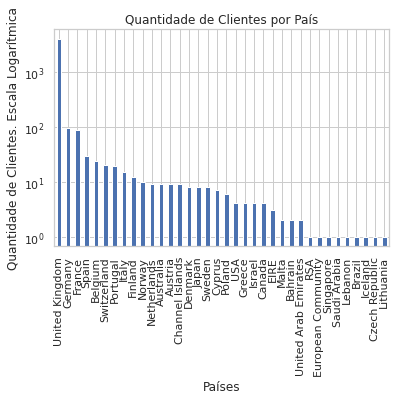

In [13]:
client_by_country.plot.bar(logy=True, xlabel="Países", ylabel='Quantidade de Clientes. Escala Logarítmica', title='Quantidade de Clientes por País')

<AxesSubplot:title={'center':'Quantidade de Clientes por País (Reino Unido Removido)'}, xlabel='Países exceto Reino Unido', ylabel='Quantidade de Clientes'>

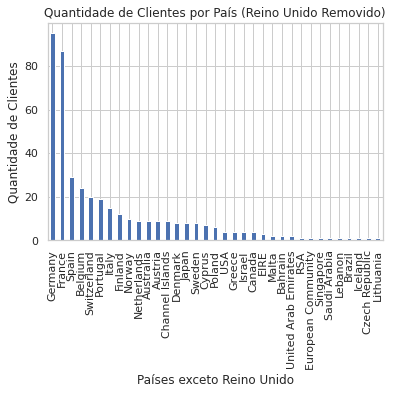

In [14]:
client_by_country[1:].plot.bar(xlabel="Países exceto Reino Unido", ylabel='Quantidade de Clientes', title='Quantidade de Clientes por País (Reino Unido Removido)')

### De quais países vem os maiores gastos? Existem países que tem poucos clientes, mas gastam muito?

* Sem muita surpresa, notamos novamente que o Reino Unido é o país onde a empresa gera maior receita.
* A Holanda, Irlanda e Alamanha seguem em seguida com maior geração de receita.
* Novamente, fora do núcleo Europeu, temos Austrália, Japão e Singapura como maiores geradores de receita para a empresa.
* A partir da divisão dos gastos dos clientes de um país pela quantidade de clientes do país, é possível notar que Irlanda, Holanda e Austrália tem poucos clientes, mas que tem forte influência relativa na receita gerada pela empresa.

### Observações:

* Países com uma maior quantidade de clientes tem a receita gerada entre os clientes mais difusa. Estratégias para aumentar as vendas para estes clientes são mais indicadas para esses lugares.
* Importante notar que os países com maior quantidade de clientes não são necessáriamente os que geram as maiores receitas. Isso é relevante para definir a importancia dos clientes desses países que, apesar de existirem em menor número, gastam mais.
* Outro fator importante é a dependência que a empresa tem em poucos clientes em países como Irlanda, Holanda e Austrália. A expansão das vendas para mais clientes nesses países pode reduzir a dependência.

<AxesSubplot:title={'center':'Gastos totais realizado por clientes de cada país'}, xlabel='Países', ylabel='Gastos. Escala Logarítmica'>

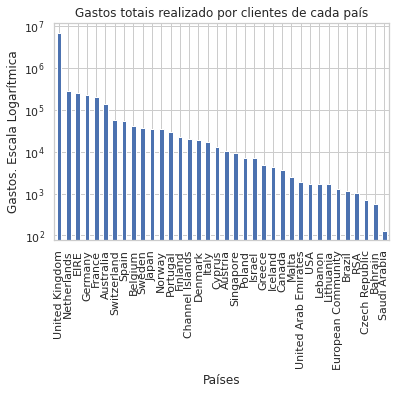

In [15]:
spent_by_country = country_df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
spent_by_country.plot.bar(logy=True, xlabel='Países', ylabel='Gastos. Escala Logarítmica', title='Gastos totais realizado por clientes de cada país')

<AxesSubplot:title={'center':'Proporção de gastos por número de clientes'}, xlabel='Países', ylabel='Gastos'>

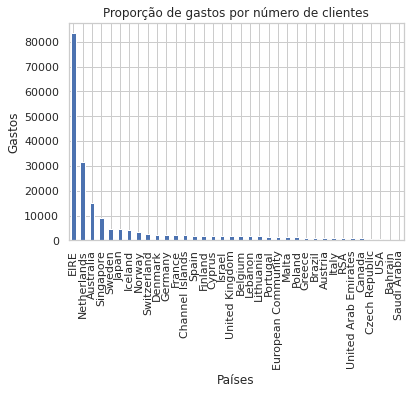

In [16]:
spent_by_client = (spent_by_country / client_by_country).sort_values(ascending=False)
spent_by_client.plot.bar(xlabel='Países', ylabel='Gastos', title='Proporção de gastos por número de clientes')

### Ainda há muito a ser explorado sobre localidade!

Seria interessante também para os times de Venda e Marketing:

* Qual a localidade dos clientes que apresentam as maiores taxas de cancelamentos? E de descontos?
* Caso exista localidades onde há um número muito grande de devoluções, por que isso tem ocorrido? Quais os custos gerados pra empresa por conta disso?
* Quais os custos associados a frete e como é possível reduzir esse custo agregando valor para o cliente?

## 2.2 Explorando informações sobre gastos:

Após explorarmos os dados de localidade dos clientes, serão exploradas informações sobre os padrões de compra dos clientes com o objetivo de identificar possíveis segmentações entre os tipos de clientes.

Além de localização, podemos segmentar os clientes por gastos e pela quantidade de tempo sem realizar uma compra.

### Perguntas:

* Como podemos segmentar os clientes por gastos? Quantos segmentos distintos parecem existir nos dados?
* Como podemos segmentar os clientes em relação ao tempo? Quais os melhores intervalos de tempo para separar os clientes?

### Como podemos segmentar os clientes por gastos? Quantos segmentos distintos parecem existir nos dados?

A partir de uma breve análise ad-hoc seguida de uma análise por boxplot e separando os dados em percentís, é possível observar:

* A empresa possui 4372 clientes distintos, destes 97 deles compõe quase 40% de toda a receita da empresa.
* De modo mais extremo, a 13% da receita da empresa é gerada por apenas 6 clientes, o que gera riscos para a empresa caso estes clientes troquem de fornecedor.
* Também nota-se que existe um pequeno grupo de clientes que geraram prejuíso a empresa. Isso pode ser devido a compras canceladas ou descontos aplicados.

### Observações:

De forma simplificada, podemos separar os clientes em 3 grupos:

* Clientes que são essenciais atualmente para a empresa por compor grande parte da receita da empresa.
* Clientes que, apesar da menor parcela em geração de receita, compõe o maior volume de vendas da empresa.
* Clientes que geram prejuízos a empresa.

A partir dessa separação, o time de marketing e vendas pode definir estratégias de expansão e fidelização a partir do perfil dos clientes.

In [178]:
client_df = data
spent_by_client = client_df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False)
spent_by_client.describe()

count      4372.000000
mean       1898.459701
std        8219.345141
min       -4287.630000
25%         293.362500
50%         648.075000
75%        1611.725000
max      279489.020000
Name: TotalPrice, dtype: float64

In [174]:
num_clients = len(client_df.drop_duplicates('CustomerID'))
total_spent = spent_by_client.sum()

exceeds_1m = spent_by_client[spent_by_client > 1_000]
exceeds_10m = spent_by_client[spent_by_client > 10_000]
exceeds_100m = spent_by_client[spent_by_client > 100_000]

n_1m = len(exceeds_1m)
n_10m = len(exceeds_10m)
n_100m = len(exceeds_100m)

print(f"Quantidade total de clientes: {num_clients}")
print(f"Quantidade de clientes com gastos acima de 1.000: {n_1m}, {round(n_1m * 100/ num_clients, 2)}%")
print(f"Quantidade de clientes com gastos acima de 10.000: {n_10m}, {round(n_10m * 100/ num_clients, 2)}%")
print(f"Quantidade de clientes com gastos acima de 100.000: {n_100m}, {round(n_100m * 100/ num_clients, 2)}%")

Quantidade total de clientes: 4372
Quantidade de clientes com gastos acima de 1.000: 1633, 37.35%
Quantidade de clientes com gastos acima de 10.000: 97, 2.22%
Quantidade de clientes com gastos acima de 100.000: 6, 0.14%


In [165]:
percentage_spent_by_1m = round(exceeds_1m.sum() * 100 / total_spent, 2)
percentage_spent_by_10m = round(exceeds_10m.sum() * 100 / total_spent, 2)
percentage_spent_by_100m = round(exceeds_100m.sum() * 100 / total_spent, 2)

print(f"{percentage_spent_by_1m}% da receita da empresa foi gerada pelos {n_1m} clientes que gastaram mais de 1.000 unidades monetárias.")
print(f"{percentage_spent_by_10m}% da receita da empresa foi gerada pelos {n_10m} clientes que gastaram mais de 10.000 unidades monetárias.")
print(f"{percentage_spent_by_100m}% da receita da empresa foi gerada pelos {n_100m} clientes que gastaram mais de 100.000 unidades monetárias.")

86.8% da receita da empresa foi gerada pelos 1633 clientes que gastaram mais de 1.000 unidades monetárias.
38.01% da receita da empresa foi gerada pelos 97 clientes que gastaram mais de 10.000 unidades monetárias.
13.17% da receita da empresa foi gerada pelos 6 clientes que gastaram mais de 100.000 unidades monetárias.


Limite dos whiskers no 1 e 99 percentil


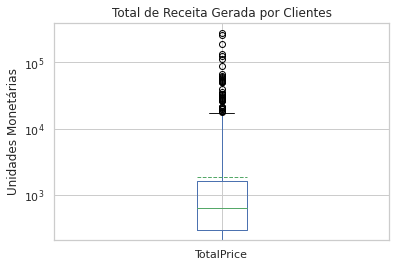

In [111]:
spent_by_client = client_df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False)
spent_by_client.plot.box(title='Total de Receita Gerada por Clientes', 
                         ylabel='Unidades Monetárias', 
                         logy=True, 
                         whis=(1, 99), 
                         meanline=True,
                         showmeans=True)

print("Limite dos whiskers no 1 e 99 percentil")

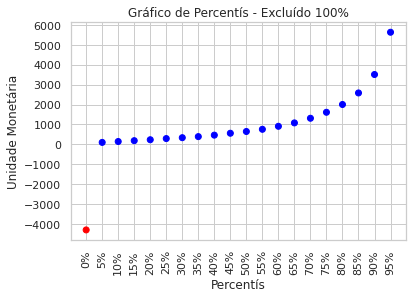

In [182]:
quantile_percentage = 5
quantile_denominator = 100 // quantile_percentage
quantiles = [spent_by_client.quantile(x / quantile_denominator) for x in range(quantile_denominator + 1)]

x = [str(x) + '%' for x in range(0, 100, quantile_percentage)]
y = quantiles[:-1]
c = ['red' if x < 0 else 'blue' for x in y]

plt.scatter(x, y, c=c)
plt.xlabel('Percentís')
plt.ylabel("Unidade Monetária")
plt.yticks(range(-4000, 6001, 1000))
plt.title('Gráfico de Percentís - Excluído 100%')
_ = plt.xticks(rotation=90)